In [36]:
import pandas as pd
import numpy as np
import mlcroissant as mlc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats.contingency import association
from scipy.stats import chi2_contingency
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Fetch the Croissant JSON-LD
croissant_dataset = mlc.Dataset('https://www.kaggle.com/datasets/asaniczka/uk-optimal-product-price-prediction/croissant/download')

# Check what record sets are in the dataset
record_sets = croissant_dataset.metadata.record_sets
print(record_sets)

# Fetch the records and put them in a DataFrame
data = pd.DataFrame(croissant_dataset.records(record_set=record_sets[0].uuid))

  -  [Metadata(UK Optimal Product Price Prediction Dataset)] Property "https://schema.org/version" is recommended, but does not exist.


[RecordSet(uuid="amz_uk_price_prediction_dataset.csv")]


In [4]:
record_set_df = data.copy()
record_set_df.head(1)

,amz_uk_price_prediction_dataset.csv/uid,amz_uk_price_prediction_dataset.csv/asin,amz_uk_price_prediction_dataset.csv/title,amz_uk_price_prediction_dataset.csv/stars,amz_uk_price_prediction_dataset.csv/reviews,amz_uk_price_prediction_dataset.csv/price,amz_uk_price_prediction_dataset.csv/isBestSeller,amz_uk_price_prediction_dataset.csv/boughtInLastMonth,amz_uk_price_prediction_dataset.csv/category
0,b'1',b'B09B96TG33',"b'Echo Dot (5th generation, 2022 release) | Bi...",4.7,15308,21.99,False,0,b'Hi-Fi Speakers'


In [5]:
# First change the name of the columns to make it more clear
record_set_df.columns = [col.lower().replace("amz_uk_price_prediction_dataset.csv/", "") for col in record_set_df.columns]
record_set_df.sample(10)

,uid,asin,title,stars,reviews,price,isbestseller,boughtinlastmonth,category
163342,b'175437',b'B0854F5DKN',b'Shiyaaka Black Perfume for Men Eau De Parfum...,4.0,481,25.99,False,50,b'Fragrances'
615395,b'663512',b'B009P4P6NS',b'Dettol Liquid Hand Wash Aloe Vera 250 ml x 6',4.6,377,9.89,False,50,b'Bath & Body'
1443013,b'1587220',b'B0BQJ5SZN5',"b""Armhole Ripped Letter Towel Embroidered Jean...",0.0,0,37.51,False,0,b'Sports & Outdoors'
1818928,b'2046216',b'B0C6F8QBTV',b'BIENKA Portable Bicycle Lock Bike Anti-Theft...,0.0,0,79.37,False,0,b'Sports & Outdoors'
260118,b'276683',b'B08356LK3F',b'SHAFAJNC Solid Color Anti-Slip Anti Scratch ...,2.4,20,27.43,False,0,b'Living Room Furniture'
177458,b'190009',b'B009F8L8ZE',"b""Roger Gallet Bois D'Orange Eau Sublime 100 ml""",4.2,25,33.42,False,0,b'Fragrances'
938866,b'1023558',b'B0CH9LL64D',b'Fishing Vest Jacket Quick Dry Mesh Vest Mult...,0.0,0,47.62,False,0,b'Sports & Outdoors'
1055547,b'1165368',b'B00N3ZPTE6',b'Sourcingmap Replacement Black CCTV Box Camer...,3.6,34,9.99,False,0,b'Surveillance Cameras'
937568,b'1022218',b'B0CCQH39TM',"b""Men's Casual Outdoor Work Fishing Travel Pho...",0.0,0,6.56,False,0,b'Sports & Outdoors'
1125737,b'1245400',b'B0B7XGKBDV',"b'Fan Heaters for Home Low Energy Silent, 2000...",3.9,277,29.99,False,0,b'Building Supplies'


### Part 1: Analyzing Best-Seller Trends Across Product Categories
Objective: Understand the relationship between product categories and their best-seller status.

#### Crosstab Analysis:

- Create a crosstab between the product category and the isBestSeller status.
- Are there categories where being a best-seller is more prevalent?

Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.

In [6]:
# Create a crosstab table to count occurrences of bestsellers per category
crosstab_result = pd.crosstab(record_set_df['category'], record_set_df['isbestseller'])

#Total count
crosstab_result['total_count'] = crosstab_result[True] + crosstab_result[False]

# Calculate the proportion of bestsellers in each category
crosstab_result['proportion_bestseller'] = crosstab_result[True] / (crosstab_result[True] + crosstab_result[False])

# Sort the result by proportion in descending order
sorted_crosstab = crosstab_result.sort_values(by='proportion_bestseller', ascending=False)

sorted_crosstab[:15]


isbestseller,False,True,total_count,proportion_bestseller
category,,,,
b'Grocery',9008,556,9564,0.058135
b'Smart Home Security & Lighting',98,6,104,0.057692
b'Health & Personal Care',9017,552,9569,0.057686
b'Mobile Phone Accessories',248,11,259,0.042471
b'Power & Hand Tools',8353,306,8659,0.035339
"b'Billiard, Snooker & Pool'",241,8,249,0.032129
b'Pet Supplies',9152,285,9437,0.030200
b'Home Brewing & Wine Making',239,7,246,0.028455
b'Mirrors',243,7,250,0.028000


In [7]:
# Yes, there are categories such as: Grocery, Smart Home Security & Lightin, Health & Personal Care and Mobile Phone Accessories
# Where they have more prevalent best sellers

#### Statistical Tests:

- Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
- Compute Cramér's V to understand the strength of association between best-seller status and category.

In [8]:
# Create a crosstab
result = pd.crosstab(record_set_df['category'], record_set_df['isbestseller'])

# Chi-square test for category and isbestseller
chi2_stats, chi2_pvalue, _, _ = chi2_contingency(result)
chi2_pvalue

# A 0 means the two variables are completely independent. No relationship between the two variables.

0.0

In [9]:
# Computing the association between variables in result using the "cramer" method
association(result, method='cramer')

# low strength of association between best-seller status and category

0.1222829439760564

#### Visualizations:

- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

In [10]:
# Since there are so many data, I am going to show in the stacked bar chat only the top 30 categories with more best sellers
# Reset index and select only the top 30 categories with more best sellers
df_30 = sorted_crosstab[:30]
df_30 = df_30.reset_index()
df_30 = df_30[["category",False, True]]
df_30 = df_30.rename_axis('index')

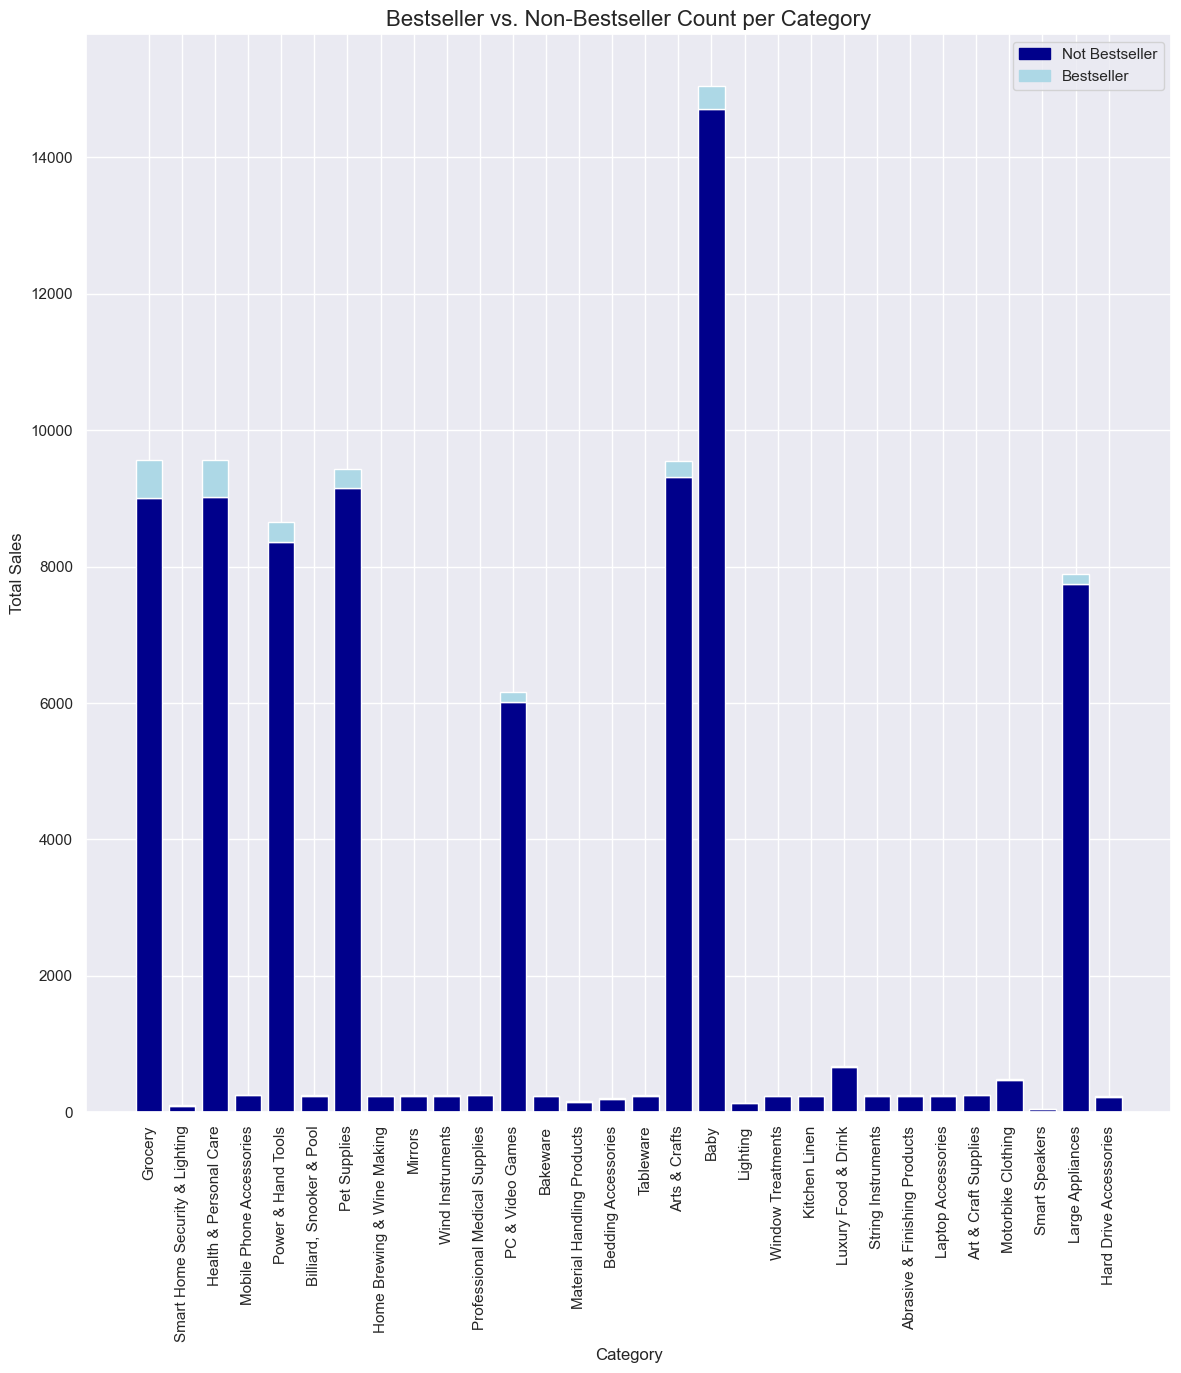

In [11]:
# Set plot style: grey grid in the background
sns.set_theme(style="darkgrid")

# Set the figure size
plt.figure(figsize=(14, 14))

# Plot stacked bars
plt.bar(df_30['category'], df_30[False], color='darkblue', label='Not Bestseller')
plt.bar(df_30['category'], df_30[True], bottom=df_30[False], color='lightblue', label='Bestseller')

# Add legend
top_bar = mpatches.Patch(color='darkblue', label='Not Bestseller')
bottom_bar = mpatches.Patch(color='lightblue', label='Bestseller')
plt.legend(handles=[top_bar, bottom_bar])

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Set title and labels
plt.title("Bestseller vs. Non-Bestseller Count per Category", fontsize=16)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)

# Show the graph
plt.show()

In [12]:
# In this plot we have the top 30 categories with most best sellers
# however, it is clear from the plot that all the categories have little best sellers compares with the non-best sellers

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands
Objective: Investigate how different product categories influence product prices.

#### Preliminary Step: Remove outliers in product prices.

For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.

Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.


In [26]:
# Remove outliers
Q1 = record_set_df["price"].quantile(0.25)
Q3 = record_set_df["price"].quantile(0.75)
IQR = Q3 - Q1
    
# Define bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
    
# Delete the outliers
mask = (record_set_df["price"] > lower_bound) & (record_set_df["price"] < upper_bound)
no_outliers = record_set_df[mask]

print(no_outliers.shape)
record_set_df.shape

(2115963, 9)


(2443651, 9)

#### Violin Plots:

- Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.
- Which product category tends to have the highest median price? Don't filter here by top categories.


In [52]:
cat_price_ = pd.concat([no_outliers["category"], no_outliers["price"]], axis=1)

#filter top 20 cat based on their counts
top_20 = cat_price_["category"].value_counts().head(20).index

# filter the cat_price_ DataFrame to include only rows where 'category' is in top_20
cat_price_20 = cat_price_[cat_price_["category"].isin(top_20)]

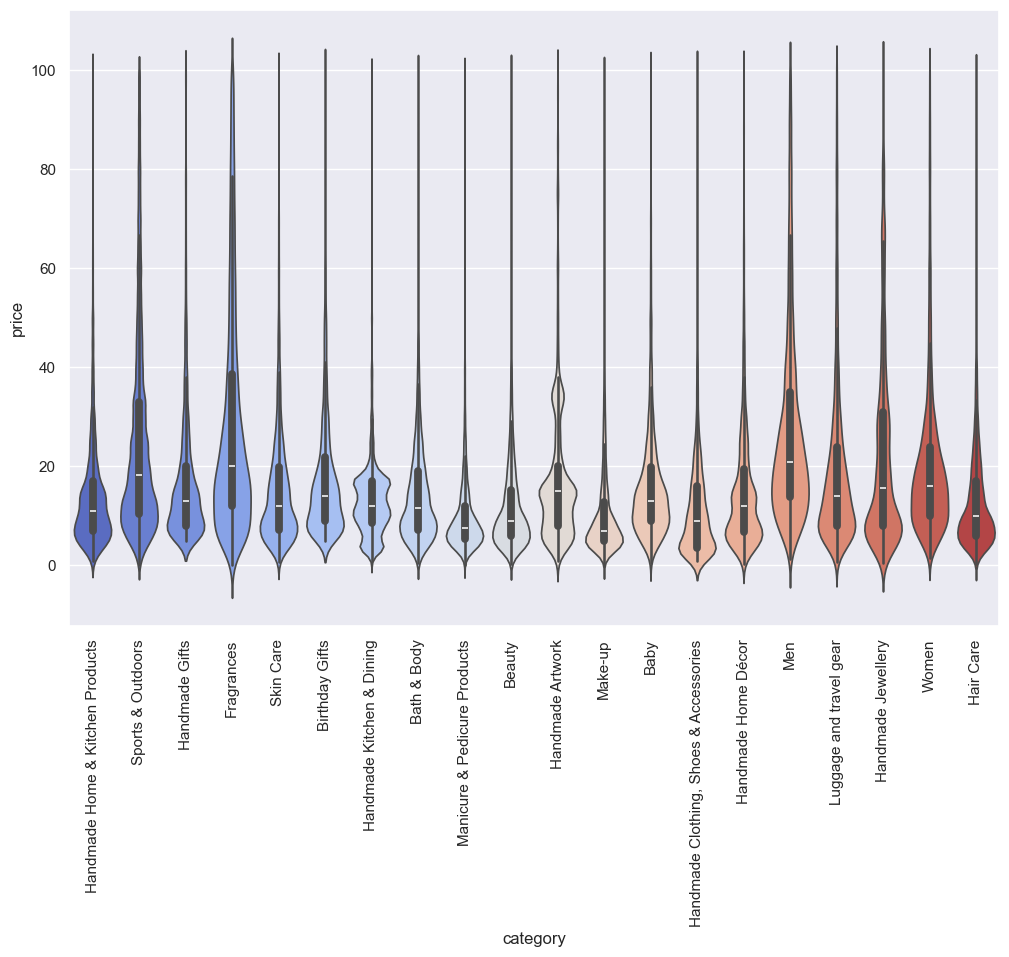

In [15]:
# Plotting a violin plot to visualize the distribution of 'Price' for each 'Category' category, using the "coolwarm" color palette
plt.figure(figsize=(12, 8))
sns.violinplot(data=cat_price_20, x="category", y="price", palette="coolwarm")
plt.xticks(rotation=90)
plt.show()

In [16]:
# Which product category tends to have the highest median price?
cat_price_median = cat_price_.groupby(["category"])["price"].median()

# idmax returns tha category with the highest median price
filter_max_median_cat = cat_price_median.idxmax()
filter_max_median_cat

b'Desktop PCs'

#### Bar Charts:

- Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
- Which product category commands the highest average price? Don't filter here by top categories.

In [ ]:
#filter top 20 cat based on their counts
top_10 = cat_price_["category"].value_counts().head(10).index

# filter the cat_price_ DataFrame to include only rows where 'category' is in top_20
cat_price_10 = cat_price_[cat_price_["category"].isin(top_10)]

# Group by category in the top 10 and average price
average_price_df = cat_price_10.groupby(["category"])["price"].mean().reset_index()

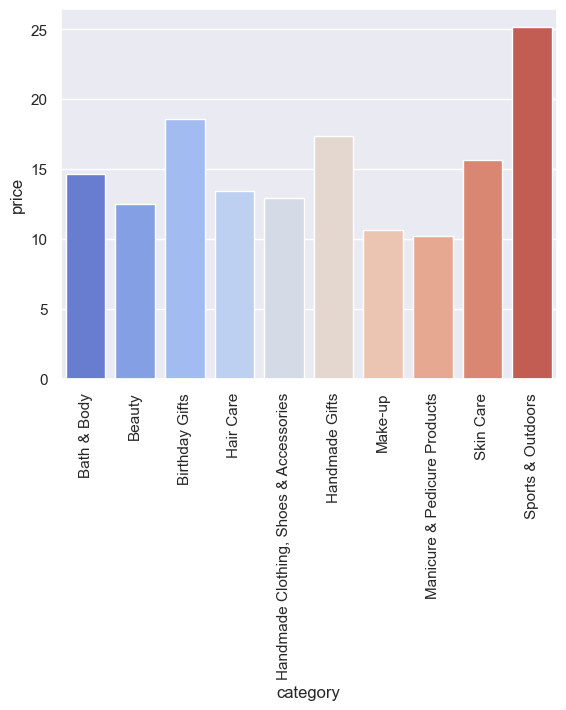

In [42]:
# Plotting a bar plot to visualize the average 'SalePrice' for each 'MSZoning' category, using the "coolwarm" color palette
sns.barplot(data=average_price_df, x="category", y="price", palette="coolwarm")
plt.xticks(rotation=90)
plt.show()

In [45]:
# Which product category commands the highest average price? Don't filter here by top categories
average_price_df = cat_price_.groupby(["category"])["price"].mean().idxmax()
average_price_df

b'Motherboards'

#### Box Plots:

- Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
- Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

In [50]:
starts_nor = no_outliers[no_outliers['reviews'] != 0]['stars']
cat_stars_wo0r = pd.concat([no_outliers['category'], starts_nor], axis =1, join='inner')

#filter top 10 cat based on their counts
top_10 = cat_stars_wo0r["category"].value_counts().head(10).index

# filter the cat_stars_wo0r DataFrame to include only rows where 'category' is in top_20
cat_price_10 = cat_stars_wo0r[cat_stars_wo0r["category"].isin(top_10)]

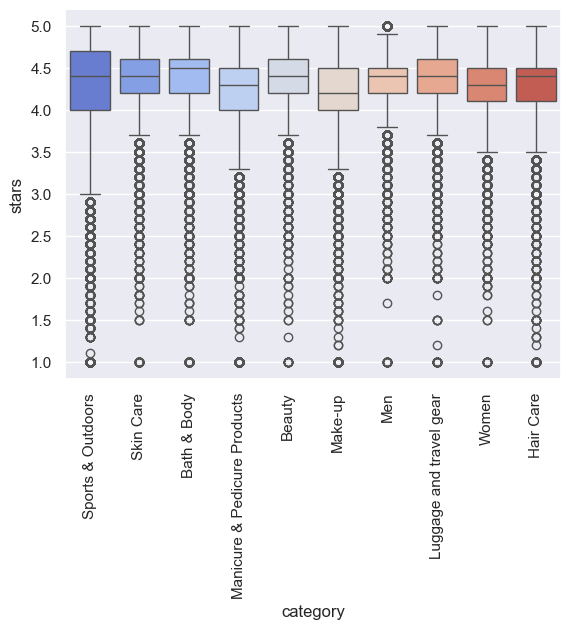

In [49]:
# Plotting a box plot to visualize the distribution 'rating' for each 'category' category, using the "coolwarm" color palette
sns.boxplot(data=cat_price_10, x="category", y="stars", palette="coolwarm")
plt.xticks(rotation=90)
plt.show()

### Part 3: Investigating the Interplay Between Product Prices and Ratings
Objective: Analyze how product ratings (stars) correlate with product prices.

#### Correlation Coefficients:

- Calculate the correlation coefficient between price and stars.
- Is there a significant correlation between product price and its rating?



In [31]:
# We create a new dataframe without the rows where there were no reviews
starts_nor = no_outliers[no_outliers['reviews'] != 0]['stars']
crosst_result = pd.concat([no_outliers['price'], starts_nor], axis =1, join='inner')

crosst_result['price'].corr(crosst_result['stars'], method='spearman') 

# There is no significat correlation between product prices and its rating

0.02465961720538042

#### Visualizations:

- Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
- Use a correlation heatmap to visualize correlations between all numerical variables.
- Examine if product prices typically follow a normal distribution using a QQ plot.

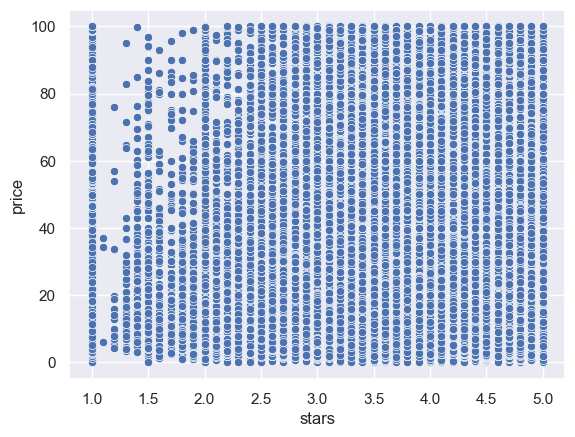

In [32]:
# Scatter plot
# Plotting a scatter plot to visualize the relationship between 'stars' and 'price'
sns.scatterplot(data=crosst_result, x='stars', y='price')
plt.show()

# There is no relationship

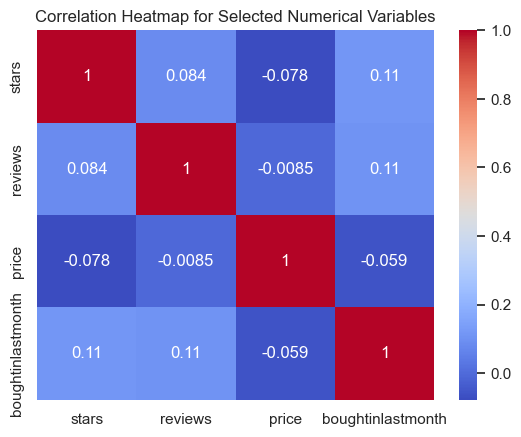

In [35]:
# Correlation heatmap for all the numerical values
num = no_outliers.select_dtypes(include="number")
correlation_matrix = num.corr()

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()

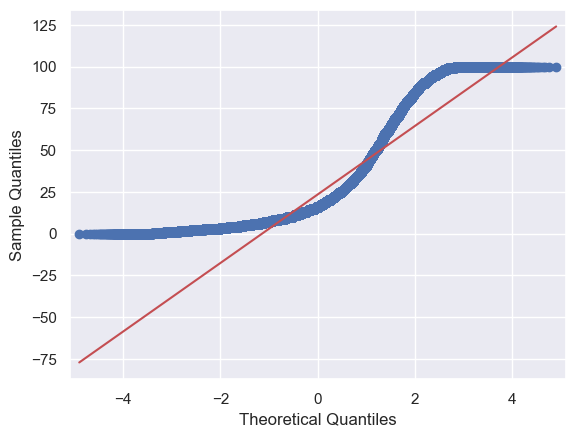

In [39]:
# QQ plot
# Generating a Q-Q plot for 'price' to check if its distribution follows a normal distribution
sm.qqplot(no_outliers['price'], line='s')
plt.show()

### Bonus
- Do the same analysis without taking out the outliers. What are your insights?

In [51]:
record_set_df.shape

(2443651, 9)

In [54]:
# Visualize the distribution of price across differnet product categories

cat_price_out = pd.concat([record_set_df["category"], record_set_df["price"]], axis=1)

#filter top 20 cat based on their counts
top_20_out = cat_price_out["category"].value_counts().head(20).index

# filter the cat_price_ DataFrame to include only rows where 'category' is in top_20
cat_price_20_out = cat_price_out[cat_price_out["category"].isin(top_20_out)]

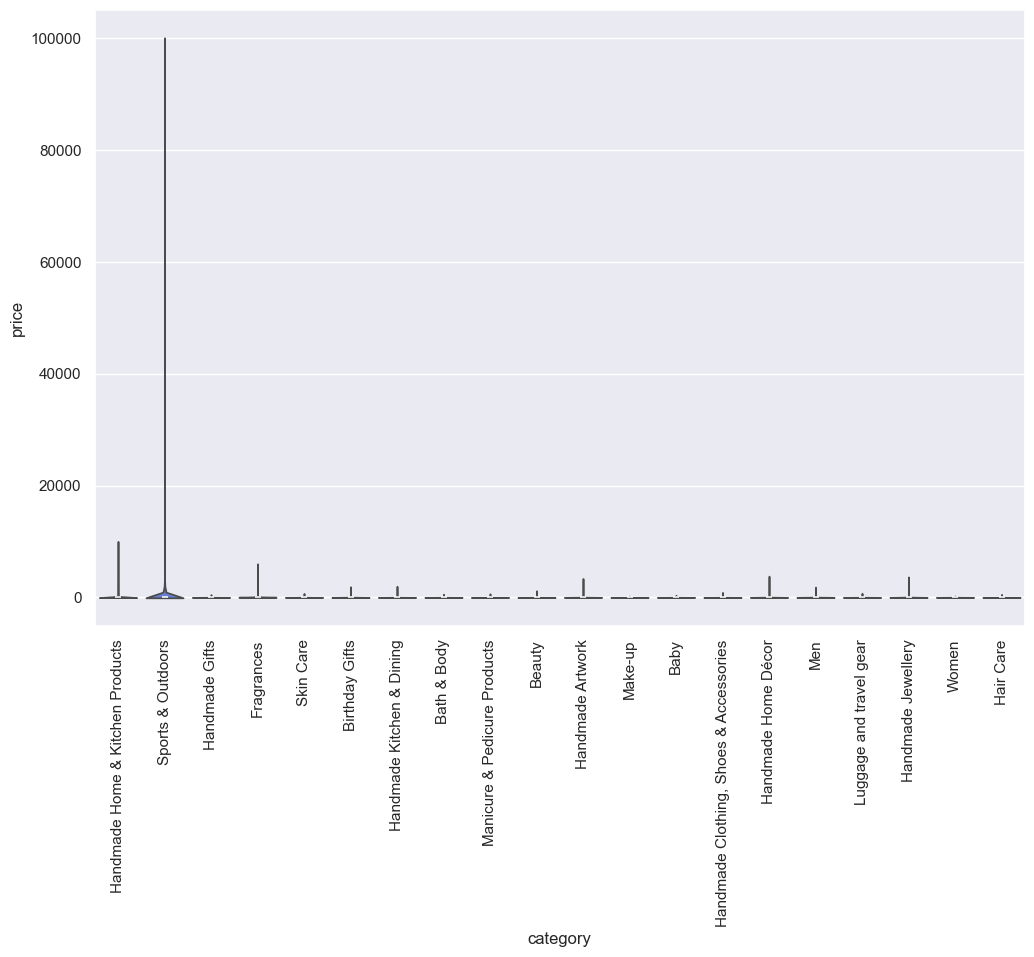

In [55]:
# Plotting a violin plot to visualize the distribution of 'Price' for each 'Category' category, using the "coolwarm" color palette
plt.figure(figsize=(12, 8))
sns.violinplot(data= cat_price_20_out, x="category", y="price", palette="coolwarm")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# the violin plot for this is illegible, doesn't give us any information

In [56]:
# Which product category tends to have the highest median price?
cat_price_median_out = cat_price_out.groupby(["category"])["price"].median()

# idmax returns tha category with the highest median price
filter_max_median_cat_out = cat_price_median_out.idxmax()
filter_max_median_cat_out

# this is also changing sice it is taking the outliers

b'Laptops'

In [57]:
# Bar Charts
# Comparison of the average of products for the top 10 categories
#filter top 20 cat based on their counts
top_10_out = cat_price_out["category"].value_counts().head(10).index

# filter the cat_price_ DataFrame to include only rows where 'category' is in top_20
cat_price_out_10 = cat_price_out[cat_price_out["category"].isin(top_10_out)]

# Group by category in the top 10 and average price
average_price_df_out = cat_price_out_10.groupby(["category"])["price"].mean().reset_index()


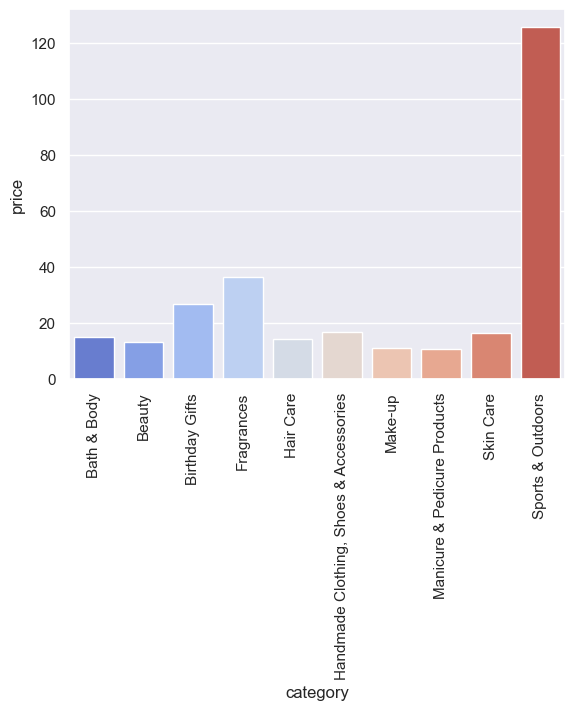

In [58]:
# Plotting a bar plot to visualize the average 'SalePrice' for each 'MSZoning' category, using the "coolwarm" color palette
sns.barplot(data=average_price_df_out, x="category", y="price", palette="coolwarm")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Here we can see that some outliers can be found mostly in the Sports and Outdoors category

In [59]:
# Which product category commands the highest average price? Don't filter here by top categories
average_price_df_out = cat_price_out.groupby(["category"])["price"].mean().idxmax()
average_price_df_out

# Laptops is still the category, out and in the top10 with higher prices

b'Laptops'

In [62]:
# distribution of product ratings based on their category using side-by-side box plots. 
# Filter out the top 10 categories based on count for better visualization.
starts_nor_out = record_set_df[record_set_df['reviews'] != 0]['stars']
cat_stars_wo0r_out = pd.concat([record_set_df['category'], starts_nor_out], axis =1, join='inner')

#filter top 10 cat based on their counts
top_10_out = cat_stars_wo0r_out["category"].value_counts().head(10).index

# filter the cat_stars_wo0r DataFrame to include only rows where 'category' is in top_20
cat_price_10_out = cat_stars_wo0r_out[cat_stars_wo0r_out["category"].isin(top_10_out)]

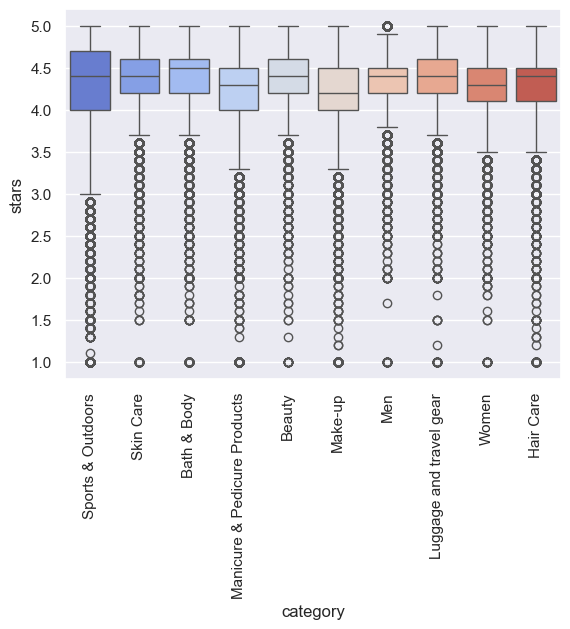

In [63]:
# Plotting a box plot to visualize the distribution 'rating' for each 'category' category, using the "coolwarm" color palette
sns.boxplot(data=cat_price_10_out, x="category", y="stars", palette="coolwarm")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# when comparing reviews and categories the box plot is very similar to the one without the outliers

In [ ]:
# Part 3 --> product prices and ratings
# Calculater the correlation coefficient between price and stars

In [65]:
# We create a new dataframe without the rows where there were no reviews
starts_nor_out = record_set_df[record_set_df['reviews'] != 0]['stars']
crosst_result_out = pd.concat([record_set_df['price'], starts_nor_out], axis =1, join='inner')

crosst_result_out['price'].corr(crosst_result_out['stars'], method='spearman') 

# There is no significat correlation between product prices and its rating
# Here the correlation is a bit lower than without the outliers

0.020035042659527956

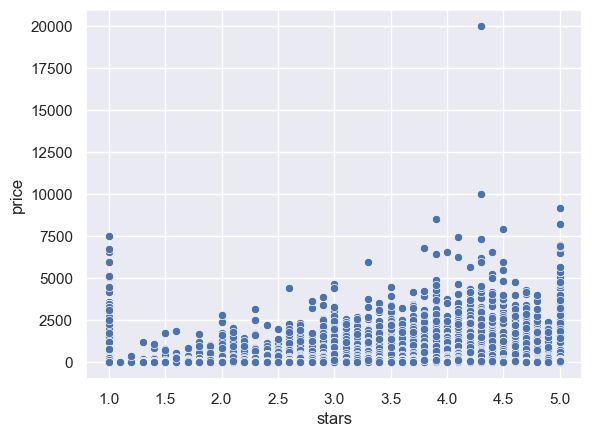

In [66]:
# Scatter plot
# Plotting a scatter plot to visualize the relationship between 'stars' and 'price'
sns.scatterplot(data=crosst_result_out, x='stars', y='price')
plt.show()

# Here we can see better that most of the most high rated products have higher prices
# The exception is the 1 rate that has a lot of expensive products
# However, there is no relationship

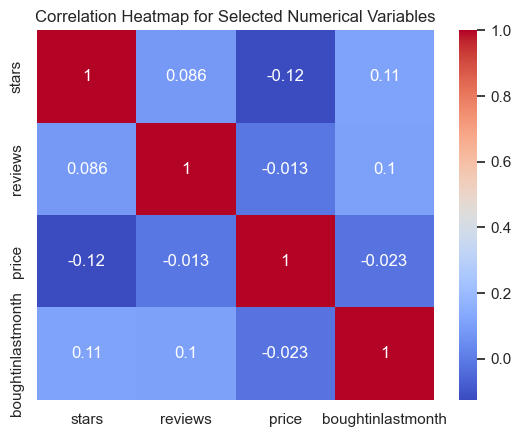

In [67]:
# Correlation heatmap for all the numerical values
num_out = record_set_df.select_dtypes(include="number")
correlation_matrix_out = num_out.corr()

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix_out, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()

In [ ]:
# here we can also see no much difference

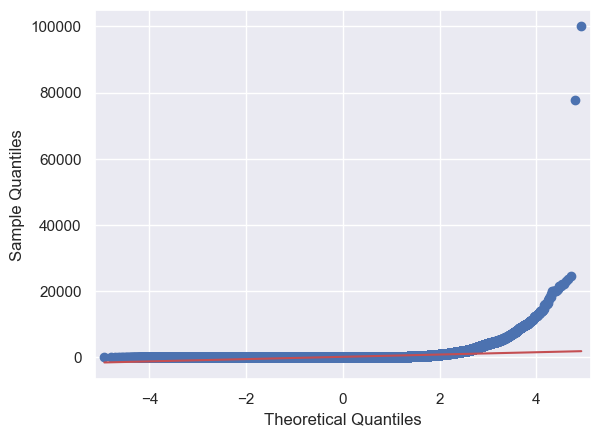

In [68]:
# QQ plot
# Generating a Q-Q plot for 'price' to check if its distribution follows a normal distribution
sm.qqplot(record_set_df['price'], line='s')
plt.show()